In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
from autoxgb import AutoXGB
import optuna
import shutil
from autoxgb.predict import AutoXGBPredict
raw_data = pd.read_csv('data_2023_08_24.csv')
raw_data['date'] = pd.to_datetime(raw_data['date'])

# Backtest Plan

* Build first XGBOOST model from 2015 to 2019 (5 Years)
* Trade every day from 2020 to 2023 (<4 years)



In [94]:
selected_features = [
    
    'btc_21d_rtns','btc_63d_rtns','btc_252d_rtns','btc_volume_chg_30d_avg',
    'btc_vol_21d','btc_vol_63d','btc_vol_252d','unstable_sign_change',
    'btc_options_put_call_vol','btc_options_put_call_trade',
    'btc_60d_skew','btc_60d_kurt',
    
    'btc_fee','miner_profit_per1Thash',
    'hashrate_5d_CHG','hashrate_21d_CHG','hashrate_63d_CHG',
    'btc_trade_val_5d_CHG','btc_trade_val_21d_CHG','btc_trade_val_63d_CHG',
    
    'US_FX_DXY_10D','US_FX_DXY_21D','US_FX_DXY_63D',
    'VIX',
    'SPX_RTN_5D','SPX_RTN_21D','SPX_RTN_63D',
    
    'ry_5y_10d_CHG','ry_5y_21d_CHG','ry_5y_63d_CHG',
    'ry_7y_10d_CHG','ry_7y_21d_CHG','ry_7y_63d_CHG',
    'ry_10y_10d_CHG','ry_10y_21d_CHG','ry_10y_63d_CHG',
    'ry_20y_10d_CHG','ry_20y_21d_CHG','ry_20y_63d_CHG',
    'ry_30y_10d_CHG','ry_30y_21d_CHG','ry_30y_63d_CHG',
    
    'T10YIE','RealGDPNowcastChgPrevious',
    'CN_PMI',
    'gtrend_chg_5D','gtrend_chg_21D','gtrend_chg_63D'
    
    
]


# Train XGBoost Model

Train dataset from 2015 to 2019 (5 Years)

In [375]:
%%time
train_data = raw_data[(raw_data['date'].dt.year<=2019) & (raw_data['date'].dt.year>=2015)]
train_data.to_csv('input/slice1.csv')

try:
  shutil.rmtree("./train_model")
except:
    pass


axgb = AutoXGB(
    train_filename="./input/slice1.csv",
    output="train_model",
    targets=["n14days_rtns"],
    idx=None,
    use_gpu=True,
    task="regression",
    features=selected_features,
    categorical_features=None,
    seed=8127,
    num_trials=100,
    time_limit=250,
    fast=False,
    num_folds=3
)

axgb.train()

2023-08-24 20:29:10,815 INFO Output directory: output_slice3
2023-08-24 20:29:10,816 WARNING No id column specified. Will default to `id`.
2023-08-24 20:29:10,817 INFO Reading training data
2023-08-24 20:29:10,882 INFO Mem. usage decreased to 0.35 Mb (70.6% reduction)
2023-08-24 20:29:10,882 INFO Problem type: single_column_regression
2023-08-24 20:29:10,883 INFO Creating folds
C:\Users\Bear\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
2023-08-24 20:29:10,891 INFO Found 0 categorical features.
2023-08-24 20:29:10,937 INFO Model config: train_filename='./input/slice1.csv' test_filename=None idx='id' targets=['n14days_rtns'] problem_type=<ProblemType.single_column_regression: 4> output='output_slice3' features=['btc_21d_rtns', 'btc_63d_rtns', 'btc_252d_rtns', 'btc_volume_chg_30d_avg', 'btc_vol_21d', 'btc_vol_63d', 'btc_vol_252d', 'unstable_sign_change', 'b

Wall time: 6min 43s


<b>Hyperparameters selected & in-sample MAE</b>

In [411]:
#Get best parameters
study = optuna.load_study(study_name="autoxgb", storage=f"sqlite:///train_model/params.db")
print(study.best_params)
print(study.best_value) #MAE

{'learning_rate': 0.010885652930165031, 'reg_lambda': 2.1507797917706246, 'reg_alpha': 6.076593114158641e-06, 'subsample': 0.6223037685755729, 'colsample_bytree': 0.7972381719374733, 'max_depth': 6, 'early_stopping_rounds': 376, 'n_estimators': 7000}
0.06044634059071541


In [380]:
#Load model
import joblib
models = []
for fold_i in range(3):
    models+=[joblib.load(os.path.join('./train_model/', f"axgb_model.{fold_i}"))]

# Lets attempt to explain the blackbox. ML Interpretability: 

In [432]:
import shap
shap.initjs()
%matplotlib inline

In [433]:
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values()

NameError: name 'bst' is not defined

# Backtest

Test dataset from 2020 to 2023 (3.5+ Years)
These are very turbulent years. 2020 was a epihany bull market. 2022 was bad due to FTX and LUNA

In [381]:
oos_data = raw_data[(raw_data['date'].dt.year>2019)][selected_features]

predictions = None
for fold_i in range(3):
    if fold_i==0:
        predictions = np.array(models[fold_i].predict(oos_data))/3
    else:
        predictions += np.array(models[fold_i].predict(oos_data))/3

<b>Predicted Next 14 days returns (Blue) vs actual (Green)</b>

<AxesSubplot:xlabel='date', ylabel='predict'>

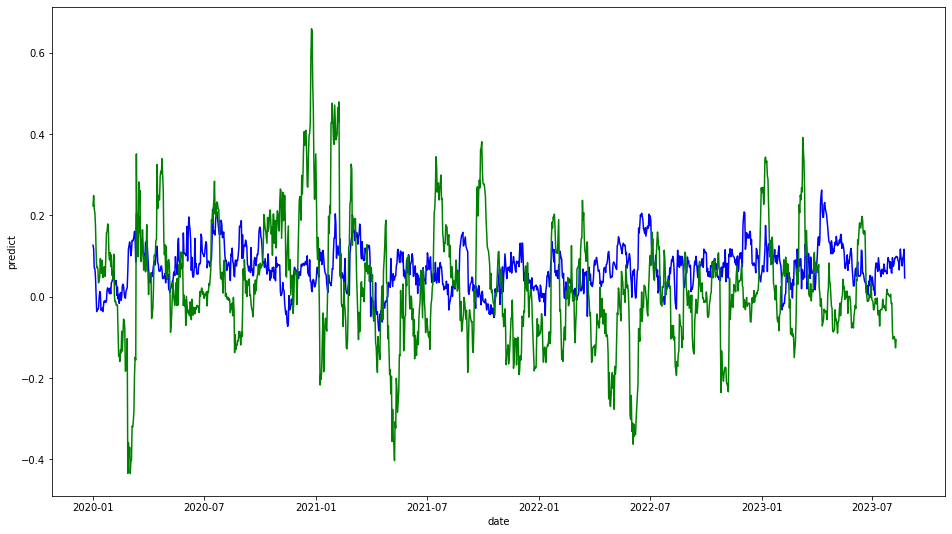

In [382]:
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(16, 9)

oos_predict = pd.DataFrame({'date':raw_data[(raw_data['date'].dt.year>2019)]['date'],
                            'predict':predictions,
                           'actual':raw_data[(raw_data['date'].dt.year>2019)]['n14days_rtns']})
sns.lineplot(x="date", y="predict",
             data=oos_predict,color='blue')
sns.lineplot(x="date", y="actual",
             data=oos_predict,color='green')



<b>Out of sample MAE double of in-sample</b>

In [383]:
from sklearn.metrics import mean_absolute_error
#Out of sample MAE
mean_absolute_error(oos_predict[oos_predict['actual'].notnull()]['actual'],oos_predict[oos_predict['actual'].notnull()]['predict'])

0.1269073551002599

<b>Backtest Logic</b>

In [408]:
trade_freq = 1 #Assume we rebalance everyday. Very important to minimize losses
data_lag = 2 #Assume that we take 2 days to receive the signal


from scipy.ndimage import shift
import math

rtns = raw_data[(raw_data['date'].dt.year>2019)]['btc_rtns']


trade = ([1]+[np.nan]*(trade_freq-1)) * math.ceil(len(rtns)/trade_freq)
trade = trade[:len(rtns)]

#Buy and Sell
#we sell when predicted next 14 days returns <=1%, arbitary selected. We want it to avoid taking risk.

bnsell = np.array([1 if x>(0.01) else 0 for x in shift(predictions,data_lag,cval=1)]) * trade

#Buy and Short
#we short when predicted next 14 days returns <=1%, arbitary selected. We want it to avoid taking risk.
bnshort = np.array([1 if x>(0) else -1 for x in shift(predictions,data_lag,cval=1)]) * trade


bt_pnl = pd.DataFrame({
    'DATE' : raw_data[(raw_data['date'].dt.year>2019)]['date'],
    'BUY_AND_HOLD':(rtns),
    'BUY_AND_SELL':(bnsell),
    'BUY_AND_SHORT':(bnshort)
    
})

bt_pnl['BUY_AND_SELL'] = bt_pnl['BUY_AND_SELL'].fillna(method='ffill')*rtns
bt_pnl['BUY_AND_SHORT'] = bt_pnl['BUY_AND_SHORT'].fillna(method='ffill')*rtns




Lets plot the cumulative PNL line. 
* Red = Buy and Hold
* Blue - Buy and Sell (Dynamically timing exit)
* Green - Buy and Short (Long/Short)

<AxesSubplot:xlabel='DATE', ylabel='BUY_AND_HOLD'>

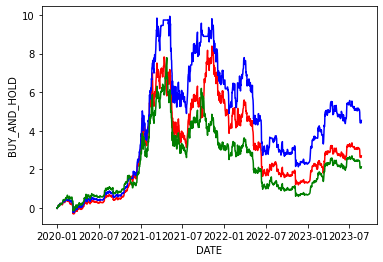

In [409]:
temp = bt_pnl[['DATE','BUY_AND_HOLD']].copy()
temp['BUY_AND_HOLD'] = (temp['BUY_AND_HOLD']+1).cumprod()-1
sns.lineplot(x="DATE", y="BUY_AND_HOLD",
             data=temp,color='red')

temp = bt_pnl[['DATE','BUY_AND_SELL']].copy()
temp['BUY_AND_SELL'] = (temp['BUY_AND_SELL']+1).cumprod()-1
sns.lineplot(x="DATE", y="BUY_AND_SELL",
             data=temp,color='blue')

temp = bt_pnl[['DATE','BUY_AND_SHORT']].copy()
temp['BUY_AND_SHORT'] = (temp['BUY_AND_SHORT']+1).cumprod()-1
sns.lineplot(x="DATE", y="BUY_AND_SHORT",
             data=temp,color='green')





Sharpe ratio of buy and sell is slightly better

In [410]:
print("Sharpe Ratio:")
print((bt_pnl.mean()*252)/(bt_pnl.std()*(252**0.5)))
print("Annualized Returns:")
print((bt_pnl.mean()*252))
print("Annualized SD:")
print((bt_pnl.std()*(252**0.5)))



Sharpe Ratio:
BUY_AND_HOLD     0.729568
BUY_AND_SELL     0.881897
BUY_AND_SHORT     0.67431
DATE                  NaN
dtype: object
Annualized Returns:
BUY_AND_HOLD     0.41470
BUY_AND_SELL     0.47354
BUY_AND_SHORT    0.38335
dtype: float64
Annualized SD:
DATE             6106 days 06:15:55.982425280
BUY_AND_HOLD                         0.568419
BUY_AND_SELL                         0.536956
BUY_AND_SHORT                        0.568506
dtype: object


<ipython-input-410-89847aaa8a8c>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print((bt_pnl.mean()*252)/(bt_pnl.std()*(252**0.5)))
<ipython-input-410-89847aaa8a8c>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print((bt_pnl.mean()*252))


# Plot Maximum Drawdown
* Red = Buy and Hold
* Blue - Buy and Sell (Dynamically timing exit)
* Green - Buy and Short (Long/Short)

<AxesSubplot:xlabel='DATE', ylabel='MAXDD'>

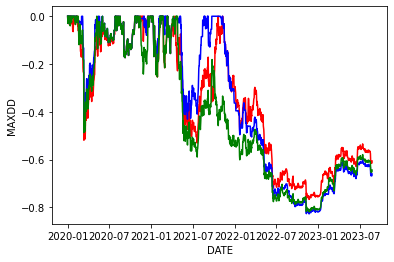

In [404]:
max_dd = {}

temp = bt_pnl[['DATE','BUY_AND_HOLD']].copy()
temp['BUY_AND_HOLD'] = (temp['BUY_AND_HOLD']+1).cumprod()
roll_max = temp['BUY_AND_HOLD'].rolling(temp.shape[0], min_periods=1).max()
temp['MAXDD'] = (temp['BUY_AND_HOLD']/roll_max)-1
max_dd['BUY_AND_HOLD'] = temp['MAXDD'].min()

sns.lineplot(x="DATE", y="MAXDD",
             data=temp,color='red')

temp = bt_pnl[['DATE','BUY_AND_SELL']].copy()
temp['BUY_AND_SELL'] = (temp['BUY_AND_SELL']+1).cumprod()
roll_max = temp['BUY_AND_SELL'].rolling(temp.shape[0], min_periods=1).max()
temp['MAXDD'] = (temp['BUY_AND_SELL']/roll_max)-1
max_dd['BUY_AND_SELL'] = temp['MAXDD'].min()

sns.lineplot(x="DATE", y="MAXDD",
             data=temp,color='blue')


temp = bt_pnl[['DATE','BUY_AND_SHORT']].copy()
temp['BUY_AND_SHORT'] = (temp['BUY_AND_SHORT']+1).cumprod()
roll_max = temp['BUY_AND_SHORT'].rolling(temp.shape[0], min_periods=1).max()
temp['MAXDD'] = (temp['BUY_AND_SHORT']/roll_max)-1
max_dd['BUY_AND_SHORT'] = temp['MAXDD'].min()


sns.lineplot(x="DATE", y="MAXDD",
             data=temp,color='green')




In [405]:
max_dd

{'BUY_AND_HOLD': -0.7663456451340276,
 'BUY_AND_SELL': -0.827095916426175,
 'BUY_AND_SHORT': -0.8184000145750943}

* In general BUY_AND_SELL and BUY_AND_SHORT have better drawdown profile than BUY_AND_HOLD except in 2022

# Out Of Sample Prediction (Lets make some money?)

In [420]:
%%time
train_data = raw_data[(raw_data['date'].dt.year>=2018) & ~raw_data['n14days_rtns'].isna()]
train_data.to_csv('input/slice2.csv')

try:
  shutil.rmtree("./test_model")
except:
    pass


axgb = AutoXGB(
    train_filename="./input/slice2.csv",
    output="test_model",
    targets=["n14days_rtns"],
    idx=None,
    use_gpu=True,
    task="regression",
    features=selected_features,
    categorical_features=None,
    seed=8127,
    num_trials=100,
    time_limit=250,
    fast=False,
    num_folds=3
)

axgb.train()

2023-08-24 21:08:04,481 INFO Output directory: test_model
2023-08-24 21:08:04,482 WARNING No id column specified. Will default to `id`.
2023-08-24 21:08:04,482 INFO Reading training data
2023-08-24 21:08:04,552 INFO Mem. usage decreased to 0.37 Mb (71.8% reduction)
2023-08-24 21:08:04,553 INFO Problem type: single_column_regression
2023-08-24 21:08:04,554 INFO Creating folds
2023-08-24 21:08:04,561 INFO Found 0 categorical features.
2023-08-24 21:08:04,611 INFO Model config: train_filename='./input/slice2.csv' test_filename=None idx='id' targets=['n14days_rtns'] problem_type=<ProblemType.single_column_regression: 4> output='test_model' features=['btc_21d_rtns', 'btc_63d_rtns', 'btc_252d_rtns', 'btc_volume_chg_30d_avg', 'btc_vol_21d', 'btc_vol_63d', 'btc_vol_252d', 'unstable_sign_change', 'btc_options_put_call_vol', 'btc_options_put_call_trade', 'btc_60d_skew', 'btc_60d_kurt', 'btc_fee', 'miner_profit_per1Thash', 'hashrate_5d_CHG', 'hashrate_21d_CHG', 'hashrate_63d_CHG', 'btc_trade_val_

Wall time: 6min 54s


In [421]:
oos_models = []
for fold_i in range(3):
    oos_models+=[joblib.load(os.path.join('./test_model/', f"axgb_model.{fold_i}"))]

In [429]:
oos_data = raw_data.iloc[[-1]][selected_features]

live_prediction = None
for fold_i in range(3):
    if fold_i==0:
        live_prediction = np.array(oos_models[fold_i].predict(oos_data))/3
    else:
        live_prediction += np.array(oos_models[fold_i].predict(oos_data))/3

In [430]:
live_prediction

array([-0.00251473], dtype=float32)

# Prediction: Bitcoin will decrease in next 2 weeks. Today 2023-08-24 , it is 26,374.30 USD